# Tutorial
This notebook demonstrates how the interferometers module can be used for the mapping of a circuit to a universal interferometer. It allows for the introduction of fabrication errors, allowing for a better understanding of how these are likely to affect produced results.

In [11]:
import lightworks as lw
from lightworks import emulator, qubit
from lightworks.interferometers import ErrorModel, Reck, dists

## Configuration

First, the test circuit is defined. In this case a hadamard and CNOT gate is used to create the $\ket{00}$ + $\ket{11}$ bell state from the input $\ket{00}$.

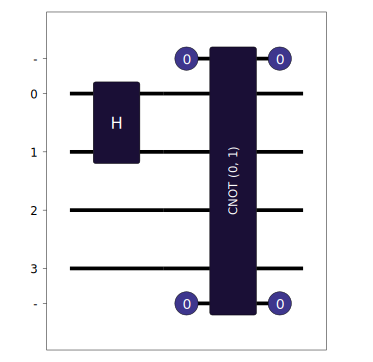

In [12]:
bell_circuit = lw.Circuit(4)
bell_circuit.add(qubit.H())
bell_circuit.add(qubit.CNOT())
bell_circuit.display()

The components of the interferometers module are then defined. First is the ErrorModel, which is a dedicated object for the introduction of process variation within an interferometer. On initial creation this will assume an ideal system, the imperfections are then modified through attributes, as will be demonstrated later.

The interferometer mapper is then defined for the conversion of a provided circuit into the interferometer. The defined ErrorModel is provided as an argument here, although if using a perfect system then this could be omitted. In this case, the universal Reck interferometer shape is chosen.

In [13]:
error_model = ErrorModel()

mapper = Reck(error_model)

Once a mapper is defined, the circuit created earlier is mapped to determine the required circuit encoding. As can be seen, the mapper is capable of preserving heralding rules from a provided circuit.

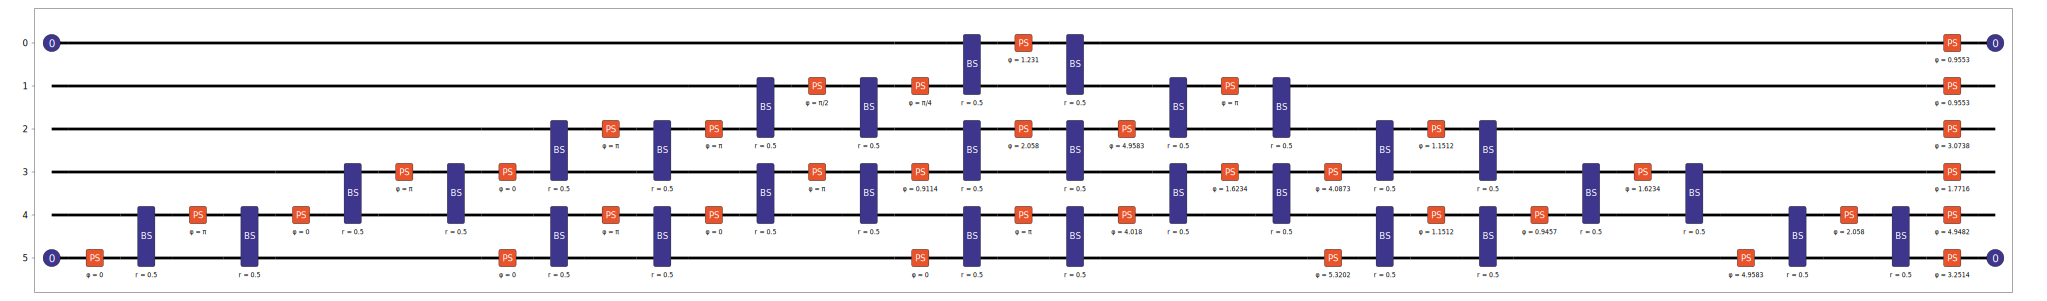

In [14]:
encoded_circuit = mapper.map(bell_circuit)

encoded_circuit.display()

### Simulation

This circuit can then be simulated to verify correct functionality using the Sampler. The required post-selection of 1 photon across each set of dual-rail encoded modes is configured, and a total of 10000 samples are drawn from the system.

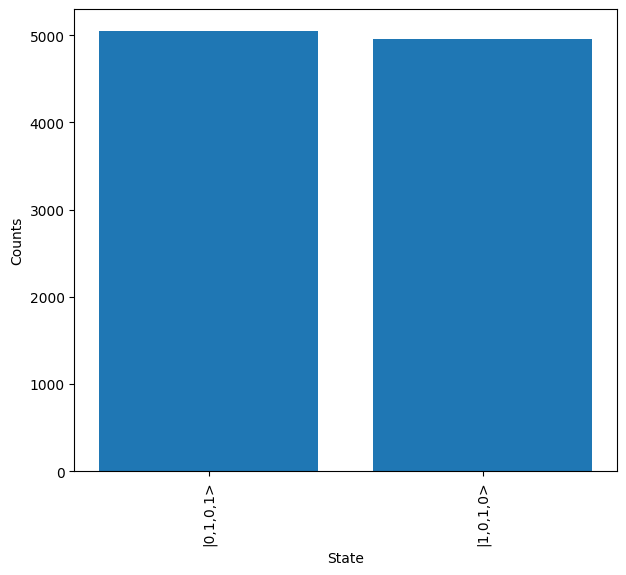

In [15]:
# Configure required post-selection for CNOT gate
post_select = lw.PostSelection()
post_select.add((0, 1), 1)
post_select.add((2, 3), 1)

sampler = emulator.Sampler(
    encoded_circuit,
    lw.State([1, 0, 1, 0]),
    10000,
    post_selection=post_select,
    random_seed=1,
)

backend = emulator.Backend("slos")
results = backend.run(sampler)

results.plot()

As expected the $\ket{1010}$ & $\ket{0101}$ outputs, corresponding to $\ket{00}$ & $\ket{11}$ in qubit encoding, are seen in near balanced numbers. This demonstrates that the functionality of the original circuit has been preserved.

## Inclusion of Errors
Errors can now be included in the system to see how the result above changes.

These are added through modification of the associated attribute for each kind of error. The value assigned to each attribute should be one of the included numerical distributions from the dists module which was imported earlier. This enables a range of different distributions to be modelled on the hardware, and it is also possible to assign custom distributions. For constant values there is also a dedicated object Constant.

Below, the reflectivity of the beam splitters used to create the reconfigurable elements of the interferometer is assigned to be a Gaussian distribution, centered around 45% with standard deviation of 2%. A minimum and maximum value can also be set to prevent any errors arising from the setting of incorrect values. In this case it is unlikely to produce an incorrect value, but they are set anyway.

The loss is then asssigned to be a constant value of 5% and phase_offset (errors in configuration of each phase element) is set to vary over a random uniform top-hat distribution between -0.1 and 0.1. 

In [16]:
error_model.bs_reflectivity = dists.Gaussian(
    0.45, 0.02, min_value=0, max_value=1
)
error_model.loss = dists.Constant(0.05)
error_model.phase_offset = dists.TopHat(-0.1, 0.1)

A new circuit is created which includes the errors configured above.

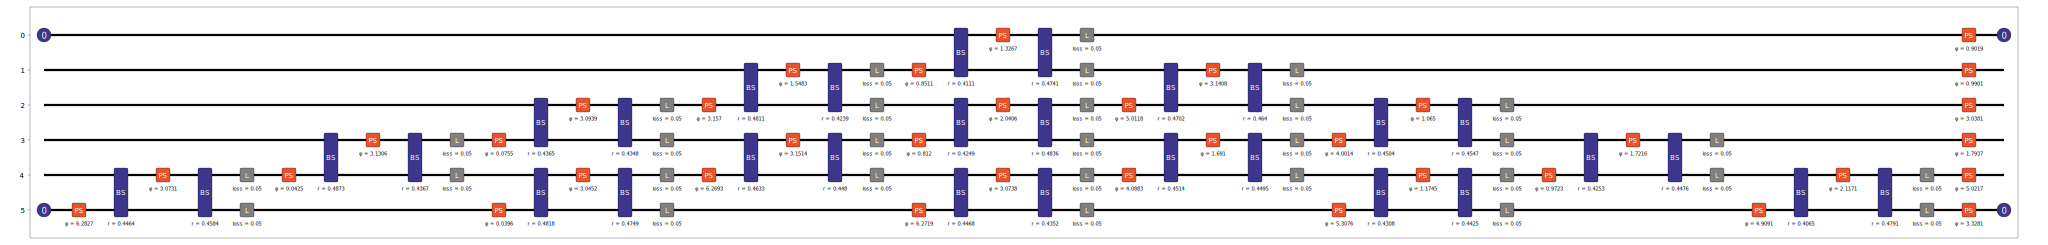

In [17]:
encoded_circuit_errors = mapper.map(bell_circuit, seed=99)

encoded_circuit_errors.display(display_loss=True)

The new circuit is then provided to the Sampler and a new set of samples generated.

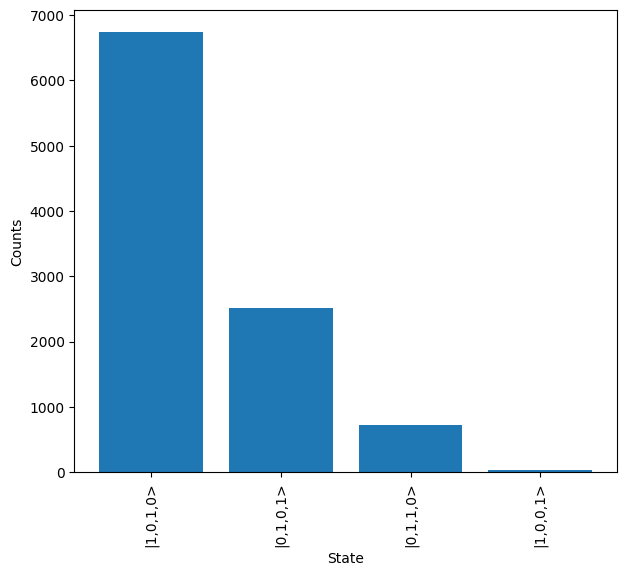

In [18]:
sampler.circuit = encoded_circuit_errors

results = backend.run(sampler)
results.plot(show=True)

It can be seen how the configuration above introduces some invalid states into the system, and also introduces a significant asymmetry between the two expected states from above. 